In [1]:
# load everything from a file
import os
import h5py
import numpy as np
import pickle
# open file
hdf_path = "/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/birdflow_models/"
species = "amewoo"
res = 48
hdf_src = os.path.join(hdf_path, f'{species}_2021_{res}km.hdf5')
file = h5py.File(hdf_src, 'r')

# get dynamic mask & nan_mask
masks = np.asarray(file['geom']['dynamic_mask']).T.astype(bool)
nan_mask = ~np.asarray(file['geom']['mask']).flatten().astype(bool)

# get x / y dimensions of the grid
x_dim = int(np.asarray(file['geom']['ncol']))
y_dim = int(np.asarray(file['geom']['nrow']))

total_cells = np.asarray(file['distr']).T.shape[1]

file.close()

In [2]:
from mixture_of_products_model import compute_marginal
from jax.nn import softmax
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
"""
Arguments
week: the week whose marginal we wish to fill into the grid to be plotted
marginal: the marginal from week "week"
masks: the dynamic masks. masks[week] is the one we care about
nan_mask: the mask used to eliminate oceans
x_dim: number of columns of final grid
y_dim: number of rows of the final grid

Returns:
A grid with all the densities of the weekly marginals filled in
"""
def make_grid(week, marginal, masks, nan_mask, x_dim, y_dim):
    medium_grid = np.empty(len(masks[0]))
    medium_grid.fill(0)
    medium_grid[masks[week]] = marginal
    big_grid = np.empty(len(nan_mask))
    big_grid.fill(np.nan)
    big_grid[list(map(lambda b : not b, nan_mask))] = medium_grid
    return big_grid.reshape(y_dim, x_dim)

def plot_weekly_marginal(params, week, masks, nan_mask, x_dim, y_dim, save_dir=None):
    marginal = compute_marginal(params, [week])
    marginal_grid = make_grid(week, marginal, masks, nan_mask, x_dim, y_dim)

    # plot stuff:
    fig, ax = plt.subplots(figsize=(7, 7))
    pos = plt.imshow(marginal_grid, cmap="winter")
    plt.colorbar(pos)
    plt.title(f"MoP Week {week} Marginal")
    ax.set_xlabel(f"ew={params['metadata']['ent_weight']}, dw={params['metadata']['dist_weight']}, dp={params['metadata']['dist_pow']}, n={params['metadata']['num_components']}")
    
    # just visualize the plot if no save path specified
    if save_dir == None:
        plt.show()
    
    # save the plot to the specified directory
    else:
        plt.savefig(os.path.join(save_dir, f'week_{week}.png'))
        plt.close()

def plot_product_k_weekly_marginal(params, k, week, masks, nan_mask, x_dim, y_dim, save_dir=None):
    marginal = softmax(params[f'MixtureOfProductsModel'][f'week_{week}'][k])
    marginal_grid = make_grid(week, marginal, masks, nan_mask, x_dim, y_dim)
    weight_k = softmax(params['MixtureOfProductsModel']['weights'])[k]
    
    # TODO: experiment with custom colormap
    fig, ax = plt.subplots(figsize=(7, 7))
    pos = plt.imshow(marginal_grid, cmap="winter")
    plt.colorbar(pos)
    plt.title(f"MoP Week {week} Marginal (component {k}, weight {weight_k:.5f})") # add weight back!
    ax.set_xlabel(f"ew={params['metadata']['ent_weight']}, dw={params['metadata']['dist_weight']}, dp={params['metadata']['dist_pow']}, n={params['metadata']['num_components']}")
    # just visualize the plot if no save path specified
    if save_dir == None:
        plt.show()
    
    # save the plot to the specified directory
    else:
        plt.savefig(os.path.join(save_dir, f'week_{week}.png'))
        plt.close()

x_dim, y_dim, x_dim * y_dim, total_cells # problem: have to convert (dynamic mask index) -> index in the 2633 grid cells -> indices in the grid given by the 91x66 matrix

# fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
# ax.plot([0,1,2], [10,20,3])
# fig.savefig('path/to/save/image/to.png')   # save the figure to file
# plt.close(fig

(91, 66, 6006, 2633)

In [3]:
import imageio
import os
"""
Concatentates images in img_dir into a .mp4, saves to save_dir
"""
def video_from_sequence(img_dir, save_dir=None):
    out_video_name = img_dir.split('/')[-1] + ".gif"
    print(f"writing video {out_video_name}")
    out_video_full_path = os.path.join(save_dir, out_video_name)
    
    img_paths = list(map(lambda img : os.path.join(img_dir, img), list(filter(lambda img : not img.startswith('.'), os.listdir(img_dir)))))
    print(img_paths)
    img_paths = sorted(img_paths, key=lambda path: int(path.split('/')[-1].split('_')[1].split('.')[0]))
    images = []
    for filename in img_paths:
        images.append(imageio.imread(filename))
    imageio.mimsave(out_video_full_path, images, loop=0, duration=50)
#     #print(img_paths)
#     cv2_fourcc = cv2.VideoWriter_fourcc(*'mp4v')

#     frame = cv2.imread(img_paths[0])
#     size = list(frame.shape)
#     del size[2]
#     size.reverse()

#     video = cv2.VideoWriter(out_video_full_path, cv2_fourcc, 24, size) #output video name, fourcc, fps, size

#     for img_path in img_paths: 
#         video.write(cv2.imread(img_path))

#     video.release()

"""
Arguments:
params: mixture of products parameters
components: array of component indices to visualize
name: name of parent directory

Description:
Creates visualizations for all weekly marginals for each of the products and the overall MOP, stores in a solidly 
organized directory
"""
def load_and_store_marginal_visualizations(params, components, name, masks, nan_mask, x_dim, y_dim):
    # create parent directory
    try:
        os.mkdir(os.path.join('visualizations', name))
    except:
        print("directory probably exists already, delete and try again")
        return
    timelapse_dir = os.path.join('visualizations', name, 'timelapses')
    os.mkdir(timelapse_dir)
    
    for k in components:
        # create directory
        save_dir = os.path.join('visualizations', name, f'Component{k}')
        os.mkdir(save_dir)
        for t in range(53):
            plot_product_k_weekly_marginal(params, k, t, masks, nan_mask, x_dim, y_dim, save_dir=save_dir)
        video_from_sequence(save_dir, timelapse_dir)
    
    # create directories and compute marginals for each of the products
    for key in list(filter(lambda key: 'Product' in key and '/' in key, list(params.keys()))): #WATCH OUT (when messing around without the [weights] key)!!
        print(f"key is {key}")
        i = int(key.split('/')[1].strip('Product'))
        save_dir = os.path.join('visualizations', name, f'Component{i}')
        os.mkdir(save_dir)
        # compute marginals of this product, store in save_dir
        for t in range(53):
            plot_product_k_weekly_marginal(params, i, t, masks, nan_mask, x_dim, y_dim, save_dir=save_dir)
        # create timelapse of marginals for this product, store in timelapse directory
        video_from_sequence(save_dir, timelapse_dir)
    
    # compute and store overall marginals
    save_dir = os.path.join('visualizations', name, "overall")
    os.mkdir(save_dir)
    for t in range(53):
        plot_weekly_marginal(params, t, masks, nan_mask, x_dim, y_dim, save_dir=save_dir)
    video_from_sequence(save_dir, timelapse_dir)
    return



writing video Component0.gif
['visualizations/test/Component0/week_0.png', 'visualizations/test/Component0/week_1.png', 'visualizations/test/Component0/week_10.png', 'visualizations/test/Component0/week_11.png', 'visualizations/test/Component0/week_12.png', 'visualizations/test/Component0/week_13.png', 'visualizations/test/Component0/week_14.png', 'visualizations/test/Component0/week_15.png', 'visualizations/test/Component0/week_16.png', 'visualizations/test/Component0/week_17.png', 'visualizations/test/Component0/week_18.png', 'visualizations/test/Component0/week_19.png', 'visualizations/test/Component0/week_2.png', 'visualizations/test/Component0/week_20.png', 'visualizations/test/Component0/week_21.png', 'visualizations/test/Component0/week_22.png', 'visualizations/test/Component0/week_23.png', 'visualizations/test/Component0/week_24.png', 'visualizations/test/Component0/week_25.png', 'visualizations/test/Component0/week_26.png', 'visualizations/test/Component0/week_27.png', 'visual

/tmp/ipykernel_422178/2618734052.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


writing video Component116.gif
['visualizations/test/Component116/week_0.png', 'visualizations/test/Component116/week_1.png', 'visualizations/test/Component116/week_10.png', 'visualizations/test/Component116/week_11.png', 'visualizations/test/Component116/week_12.png', 'visualizations/test/Component116/week_13.png', 'visualizations/test/Component116/week_14.png', 'visualizations/test/Component116/week_15.png', 'visualizations/test/Component116/week_16.png', 'visualizations/test/Component116/week_17.png', 'visualizations/test/Component116/week_18.png', 'visualizations/test/Component116/week_19.png', 'visualizations/test/Component116/week_2.png', 'visualizations/test/Component116/week_20.png', 'visualizations/test/Component116/week_21.png', 'visualizations/test/Component116/week_22.png', 'visualizations/test/Component116/week_23.png', 'visualizations/test/Component116/week_24.png', 'visualizations/test/Component116/week_25.png', 'visualizations/test/Component116/week_26.png', 'visualizat

KeyboardInterrupt: 

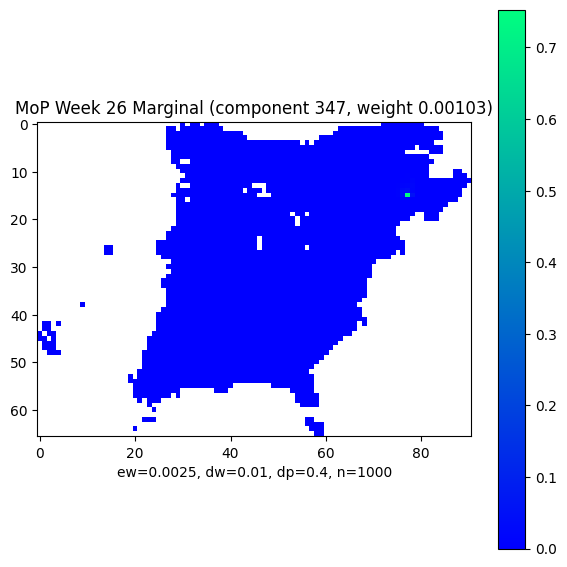

In [5]:
import jax.numpy as jnp
fname = "/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/mixture_of_products/experiments/test/mop_params_amewoo_48km_obs1.0_ent0.0025_dist0.01_pow0.4_n1000_key42.pkl"
with open(fname, 'rb') as f:
    mop_params = pickle.load(f)
load_and_store_marginal_visualizations(mop_params, [0, 116, 237, 347, 487, 594, 698, 826, 949], "test", masks, nan_mask, x_dim, y_dim)


In [16]:
from jax.nn import softmax
fname = "/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/mixture_of_products/experiments/varying_entropy_weight_debugged/mop_params_amewoo_48km_obs1.0_ent0.0001_dist0.01_pow0.4_n1000_key42_scale20.0_unboxed.pkl"
with open(fname, 'rb') as f:
    mop_params = pickle.load(f)
weights = softmax(mop_params['MixtureOfProductsModel']['weights'])
#print(weights)
collapsed_indices = list(filter(lambda tup: tup[1] < 1e-5, enumerate(weights)))
#print(collapsed_indices)
print(len(collapsed_indices))
print(len(collapsed_indices)/1000)

uncollapsed_indices = list(filter(lambda tup: tup[1] > 1e-5, enumerate(weights)))

print(len(uncollapsed_indices))
print(list(map(lambda tup: tup[0], uncollapsed_indices[::20])))
print(list(map(lambda tup: tup[0], collapsed_indices[::100])))

829
0.829
171
[0, 116, 237, 347, 487, 594, 698, 826, 949]
[1, 122, 243, 362, 478, 605, 724, 844, 963]


In [5]:
# load and store visualizations for parameters with all the different entropy weights
ews = [1.0, 10.0]

for ew in ews:
    ew_f=f"/work/pi_drsheldon_umass_edu/birdflow_modeling/jacob_independent_study/mixture_of_products/experiments/varying_entropy_weight_debugged/mop_params_amewoo_48km_obs1.0_ent{ew}_dist0.01_pow0.4_n1000_key42_dim5_scale3.0.pkl"
    with open(ew_f, 'rb') as f:
        mop_params = pickle.load(f)
    load_and_store_marginal_visualizations(mop_params, [0, 100, 200, 300, 400, 500, 600, 700, 800, 900], f"fine_tuned_ew{ew}_dim5_scale3", masks, nan_mask, x_dim, y_dim)
    
    

writing video Component0.gif
['visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_0.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_1.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_10.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_11.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_12.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_13.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_14.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_15.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_16.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_17.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_18.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_19.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_2.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component0/week_20

/tmp/ipykernel_113229/2618734052.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


writing video Component100.gif
['visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_0.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_1.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_10.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_11.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_12.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_13.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_14.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_15.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_16.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_17.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_18.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_19.png', 'visualizations/fine_tuned_ew1.0_dim5_scale3/Component100/week_2.png', 'visualizations/fine_tuned_ew1.0_di

KeyboardInterrupt: 